In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
from sklearn.model_selection import GridSearchCV
plt.style.use('seaborn-whitegrid')

In [2]:
path = 'TEST TASK (dataset).csv'         # шлях до датасету
data = pd.read_csv(path)
data

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.000000,0.000000,0.000000,ios,0.000000,0.000000,0.000000,0.000000
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000,0.000000,0.000000,android,0.000000,0.000000,0.000000,0.000000
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000,0.000000,0.000000,android,0.000000,0.000000,0.000000,0.000000
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000,0.000000,0.000000,ios,0.000000,0.000000,0.000000,0.000000
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.000000,0.000000,0.000000,android,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467827,11.0,11.0,11.0,11.0,9,9,9,9,10,10,...,2021-12-30,COUNTRY_141,0.037158,0.037158,0.037158,ios,0.000000,4.174198,0.037158,4.211356
1467828,2.0,3.0,6.0,7.0,5,9,11,13,6,10,...,2021-12-30,COUNTRY_141,0.039256,0.039256,0.091267,ios,4.705161,10.967580,0.091267,15.764008
1467829,3.0,5.0,11.0,13.0,5,9,15,18,5,10,...,2021-12-30,COUNTRY_141,0.000000,0.000000,0.000000,ios,0.000000,14.938221,0.000000,14.938221
1467830,5.0,5.0,5.0,5.0,24,24,24,24,24,24,...,2021-12-30,COUNTRY_141,0.177550,0.177550,0.177550,ios,0.000000,7.402224,0.177550,7.579774


Переведемо колонку дату в тип datetime та розділимо її на 3 колонки: рік, номер місяця та номер дня в місяці.

In [3]:
data['install_date'] = pd.to_datetime(data['install_date'])
print('Min date = ', data['install_date'].min())
print('Max date = ', data['install_date'].max())

Min date =  2021-12-01 00:00:00
Max date =  2022-01-31 00:00:00


In [4]:
date = data['install_date']
data['year'] = date.dt.year
data['month'] = date.dt.month
data['day'] = date.dt.day

data = data.drop(['install_date'],axis=1)

Замінюємо nan values на нульові значення (в даному випадку nan values відносно дуже мало і тому така проста заміна не буде впливати на результат)

In [5]:
print('Кількість nan values у колонках:')
(data.shape[0]-data.count()).sort_values()

Кількість nan values у колонках:


chapters_finished_session3       0
chapters_opened_session1         0
chapters_opened_session3         0
chapters_opened_session9         0
chapters_closed_session1         0
                              ... 
tickets_spent_day0               0
total_sessions_day0           1365
total_sessions_day1           1367
total_sessions_day3           1368
total_sessions_day7           1374
Length: 65, dtype: int64

In [6]:
data = data.fillna(0.0)

Кодуємо колонки типу string

In [7]:
cat_col = ['media_source', 'country_code', 'platform']   # виокремимо в окрему змінну категоріальні дані

In [8]:
# кодуємо дані з відповідних колонок
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col_name in cat_col:
  le.fit(data[col_name])
  data[col_name] = le.transform(data[col_name])

In [9]:
le.classes_        # перевірімо в які класи закодувалися назви платформ, щоб потім побудувати діаграма 

array(['android', 'ios'], dtype=object)

In [10]:
data['country_code'].unique()             # Перевіримо чи спрацювало кодування

array([ 41,  48, 117, 156,  38, 164,  61,  28,  63, 208,  35,  18,  17,
       126, 194, 202,  43, 150, 172, 189, 153,  57, 106,  34,  14, 143,
         9, 133, 141,  51, 203, 140,   5, 114, 168,  74, 122,  64, 161,
       188, 180,  46, 132,  66, 191, 181, 213, 169, 102, 104, 139, 160,
       212,  73, 176, 100, 118, 215,  12, 219,  19,  58, 144, 204,  70,
       216, 207, 124, 125,  40, 137,  81,  78,  99,   7,  92,   1,  98,
         3,  79,  96, 128,  54,  56,  11,  91,  62, 115, 121,  36, 146,
       136,  75,  72, 170,   4,  13,  45, 178,   8,  77,  71,  76, 190,
       185, 209,  47,   2, 162, 192,  24, 110,  26, 101,  65, 217, 173,
       183, 220,   0,  39, 211,  55, 130, 195,  80,  89, 201, 147, 142,
        10, 134,  60,  25,  42,  15, 167,  90,  88, 151,  31, 148,  97,
        87,  52, 218, 158, 159,  30, 206, 205, 119,  50,  49, 221,  82,
        94,  27,  84, 171, 200,  37, 108, 186, 157, 223,  23, 149, 113,
       129,  22,  16, 182, 193,  86, 163, 197, 138, 116,  29, 17

Візуалізація даних

In [11]:
def vis(data,main_atrr,secon):     # функція, яка зображує точки даних у площині двох координат
  y = data[main_atrr]
  x = data[secon]
  plt.plot(x,y,'o')
  plt.xlabel(secon)
  plt.ylabel(main_atrr)

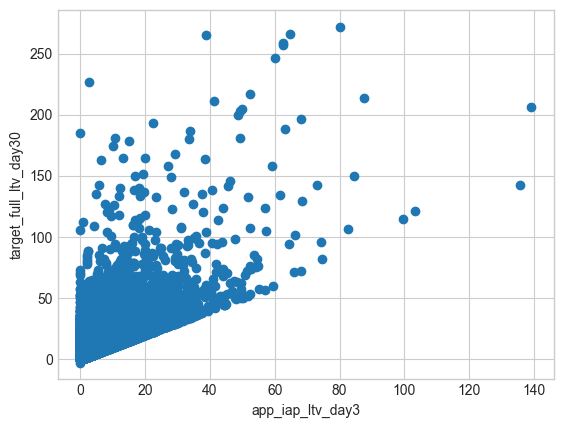

In [12]:
vis(data, 'target_full_ltv_day30', 'app_iap_ltv_day3')   

Гістограма 

<AxesSubplot:xlabel='chapters_finished_day7', ylabel='Count'>

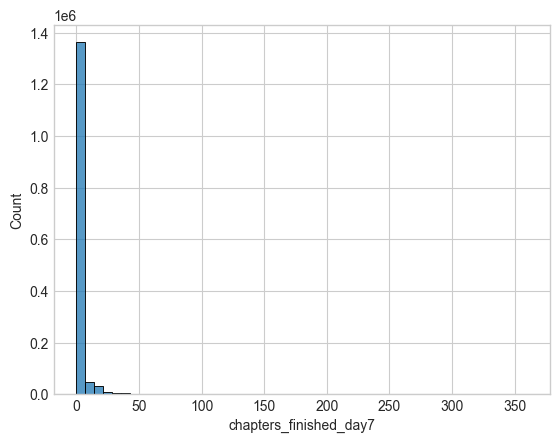

In [13]:
var = 'chapters_finished_day7'
sns.histplot(data=data,x=var,bins=50)

In [49]:
print('Дохід від гравців, у яких '+str(var)+'=0', data[data[var]==0]['target_full_ltv_day30'].sum())
print('Дохід від гравців, у яких '+str(var)+'!=0', data[data[var]!=0]['target_full_ltv_day30'].sum())
print('Середній дохід від гравців, у яких '+str(var)+'=0', data[data[var]==0]['target_full_ltv_day30'].mean())
print('Середній дохід від гравців, у яких '+str(var)+'!=0', data[data[var]!=0]['target_full_ltv_day30'].mean())     

Дохід від гравців, у яких chapters_finished_day7=0 6113.190245197164
Дохід від гравців, у яких chapters_finished_day7!=0 370932.99803929316
Середній дохід від гравців, у яких chapters_finished_day7=0 0.0068819912519331155
Середній дохід від гравців, у яких chapters_finished_day7!=0 0.6400428579008551


Зображуємо діаграму, щоб побачити як розподілені різні платформи у користувачів

([<matplotlib.patches.Wedge at 0x12f3303d0>,
 [Text(0.35494489906126164, 1.041159987048288, 'ios'),
  Text(-0.3549449965416937, -1.0411599538159433, 'android')],
 [Text(0.19360630857886996, 0.5679054474808842, '39.5%'),
  Text(-0.19360636175001475, -0.5679054293541509, '60.5%')])

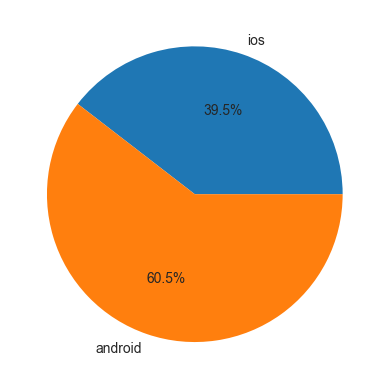

In [15]:
plt.pie([data['platform'].sum(),data['platform'].shape[0] - data['platform'].sum()], labels = ['ios','android'], autopct='%1.1f%%')

Кореляція

In [16]:
target_columns = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']
ord_col = list(set(data.columns).difference(set(target_columns)))   

In [17]:
print(ord_col)

['chapters_closed_day7', 'app_iap_ltv_day3', 'total_sessions_day1', 'diamonds_spent_day1', 'chapters_closed_session9', 'chapters_opened_session1', 'total_sessions_day7', 'retained_day1', 'chapters_finished_session3', 'diamonds_received_day7', 'day', 'media_source', 'diamonds_spent_day3', 'diamonds_spent_day0', 'chapters_finished_day3', 'chapters_opened_session3', 'tickets_spent_day0', 'month', 'retained_day7', 'chapters_finished_day1', 'diamonds_spent_session1', 'platform', 'chapters_opened_day7', 'chapters_closed_session1', 'chapters_finished_day0', 'retained_day3', 'target_full_ltv_day30', 'diamonds_received_day0', 'chapters_closed_day1', 'total_sessions_day0', 'tickets_spent_session3', 'chapters_closed_session3', 'app_sub_ltv_day1', 'chapters_finished_session1', 'diamonds_spent_session3', 'app_sub_ltv_day3', 'chapters_finished_day7', 'tickets_spent_day1', 'chapters_finished_session9', 'tickets_spent_day3', 'chapters_opened_day3', 'app_iap_ltv_day0', 'country_code', 'chapters_opened_

In [18]:
data = data.astype('float64')

In [19]:
np.all(data.dtypes=='float64')

True

In [50]:
data.describe()   # статистичні характеристики наших даних

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30,year,month,day
count,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,...,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06
mean,1.845580e+00,2.191869e+00,2.606548e+00,3.110570e+00,1.234763e+00,1.498150e+00,1.772233e+00,2.055170e+00,2.099693e+00,2.382293e+00,...,1.090574e-02,1.325368e-02,3.954172e-01,2.203037e-02,2.139268e-01,2.091572e-02,2.568728e-01,2.021392e+03,7.685820e+00,1.861522e+01
std,2.530274e+00,3.620912e+00,5.345442e+00,7.884984e+00,3.048333e+00,3.975010e+00,5.033945e+00,6.325564e+00,3.117375e+00,4.077269e+00,...,6.009280e-02,7.472105e-02,4.889403e-01,3.088758e-01,2.097916e+00,1.601929e-01,2.274466e+00,4.882406e-01,5.370647e+00,9.568710e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,-2.829604e+00,0.000000e+00,0.000000e+00,-2.777195e+00,2.021000e+03,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.021000e+03,1.000000e+00,1.000000e+01
50%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.021000e+03,1.200000e+01,2.100000e+01
75%,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.022000e+03,1.200000e+01,2.700000e+01
max,7.710000e+02,7.710000e+02,7.710000e+02,9.050000e+02,7.300000e+01,3.590000e+02,3.600000e+02,3.600000e+02,7.700000e+01,3.600000e+02,...,1.974900e+01,1.997062e+01,1.000000e+00,4.545741e+01,2.687878e+02,3.393084e+01,2.720042e+02,2.022000e+03,1.200000e+01,3.100000e+01


In [21]:
# виберемо змінні, які мають кореляцію більше ніж 0.15 з головною змінною
corr = data[ord_col].corr()
corr_target = corr['target_full_ltv_day30']
corr_target = corr_target[corr_target<1]
a = np.abs(corr_target).sort_values()
cor_min = 0.15
corr_list = a[a>cor_min]
corr_list

chapters_opened_session1      0.150980
chapters_closed_day1          0.152283
tickets_spent_session1        0.157572
chapters_finished_session1    0.163845
retained_day1                 0.177551
chapters_closed_day3          0.183482
retained_day3                 0.187840
retained_day7                 0.192130
total_sessions_day0           0.195521
chapters_closed_day7          0.217513
total_sessions_day1           0.229253
tickets_spent_session3        0.229660
chapters_opened_session3      0.235190
chapters_finished_session3    0.244130
total_sessions_day3           0.256603
tickets_spent_day0            0.269870
app_sub_ltv_day3              0.274343
total_sessions_day7           0.284839
chapters_opened_day0          0.286784
diamonds_received_day0        0.290158
chapters_finished_day0        0.292734
tickets_spent_session9        0.298779
ad_ltv_day0                   0.300505
tickets_spent_day1            0.310353
chapters_opened_session9      0.313546
chapters_finished_session

In [22]:
print('кількість змінних, у яких кореляція з головною змінною>'+str(cor_min)+' = ', corr_list.shape[0])
main_col = list(corr_list.index)

кількість змінних, у яких кореляція з головною змінною>0.15 =  49


Вибір моделі

In [23]:
X = np.array(data[main_col])
y = np.array(data['target_full_ltv_day30'])
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, random_state=42)

In [24]:
print('shape(X) = ', X.shape)
print('shape(y) = ', y.shape)

shape(X) =  (1467832, 49)
shape(y) =  (1467832,)


Linear regression

In [25]:
model1 = LinearRegression().fit(X_train, y_train)
print('test R2_score = ', model1.score(X_test, y_test))
print('train R2_score = ', model1.score(X_train, y_train))
print('test rmse_score = ', np.sqrt(mse(y_test, model1.predict(X_test))))
print('test mape_score = ', mape(y_test, model1.predict(X_test)))
print('test mae_score = ', mae(y_test, model1.predict(X_test)))

test R2_score =  0.7638522762409652
train R2_score =  0.7990838274415739
test rmse_score =  1.072284493316548
test mape_score =  99494980624846.48
test mae_score =  0.13278890084457187


In [26]:
print('(mape для y!=0):',mape(y_test[y_test!=0], model1.predict(X_test)[y_test!=0]))

(mape для y!=0): 22.86196157083573


MLPRegressor

In [27]:
# процес вибору адекватних параметрів для нейромережі
'''alph1 = [0.01,0.03,0.05,0.08,0.12]
alph2 = [0.001,0.003,0.005,0.008,0.012]

for i in alph1:
  model2 = MLPRegressor(random_state=42, hidden_layer_sizes=(64,32), max_iter=500, alpha=i, n_iter_no_change=5).fit(X_train, y_train)
  print('alpha = ', i)
  print('test score = ', model2.score(X_test, y_test))
  print('train score = ', model2.score(X_train, y_train))
  print('\n')
  
for i in alph2:
  model2 = MLPRegressor(random_state=42, hidden_layer_sizes=(64,32), max_iter=500, alpha=i, n_iter_no_change=5).fit(X_train, y_train)
  print('alpha = ', i)
  print('test score = ', model2.score(X_test, y_test))
  print('train score = ', model2.score(X_train, y_train))
  print('\n')'''

"alph1 = [0.01,0.03,0.05,0.08,0.12]\nalph2 = [0.001,0.003,0.005,0.008,0.012]\n\nfor i in alph1:\n  model2 = MLPRegressor(random_state=42, hidden_layer_sizes=(64,32), max_iter=500, alpha=i, n_iter_no_change=5).fit(X_train, y_train)\n  print('alpha = ', i)\n  print('test score = ', model2.score(X_test, y_test))\n  print('train score = ', model2.score(X_train, y_train))\n  print('\n')\n  \nfor i in alph2:\n  model2 = MLPRegressor(random_state=42, hidden_layer_sizes=(64,32), max_iter=500, alpha=i, n_iter_no_change=5).fit(X_train, y_train)\n  print('alpha = ', i)\n  print('test score = ', model2.score(X_test, y_test))\n  print('train score = ', model2.score(X_train, y_train))\n  print('\n')"

In [28]:
model2 = MLPRegressor(random_state=42, hidden_layer_sizes=(64,32), max_iter=500, alpha=0.001, n_iter_no_change=5).fit(X_train, y_train)
print('test R2_score = ', model2.score(X_test, y_test))
print('train R2_score = ', model2.score(X_train, y_train))
print('test rmse_score = ', np.sqrt(mse(y_test, model2.predict(X_test))))
print('test mape_score = ', mape(y_test, model2.predict(X_test)))
print('test mae_score = ', mae(y_test, model2.predict(X_test)))

test R2_score =  0.7844315226453266
train R2_score =  0.8005214303320115
test rmse_score =  1.0244971881004095
test mape_score =  28819444574364.25
test mae_score =  0.09425775305817256


In [29]:
print('(mape для y!=0):',mape(y_test[y_test!=0], model2.predict(X_test)[y_test!=0]))

(mape для y!=0): 7.521882858943411


In [30]:
model3 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42, loss='squared_error').fit(X_train, y_train)
print('test R2_score = ', model3.score(X_test, y_test))
print('train R2_score = ', model3.score(X_train, y_train))

test R2_score =  0.7825550247756997
train R2_score =  0.884298616418279


In [31]:
print('test rmse_score = ', np.sqrt(mse(y_test, model3.predict(X_test))))
print('test mape_score = ', mape(y_test, model3.predict(X_test)))
print('test mae_score = ', mae(y_test, model3.predict(X_test)))

test rmse_score =  1.0289465890850418
test mape_score =  30619358834314.445
test mae_score =  0.0895138132817083


In [48]:
print('(mape для y!=0):',mape(y_test[y_test!=0], model3.predict(X_test)[y_test!=0]))

(mape для y!=0): 5.21730293656799


In [36]:
# збереження натренованих моделей
def download_models(models):
  import pickle

  with open('models1.pkl', 'wb') as f:
    pickle.dump(models, f)


In [37]:
models = [model1, model2, model3]
download_models(models)

In [51]:
with open('test.npy', 'wb') as f:
    np.save(f, X_test)
    np.save(f, y_test)